In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

## Get FROG-kb calculations

In [32]:
oncoarray=pd.read_csv("/cellar/users/mpagadal/Programs/FROGAncestryCalc/output/oncoarray_likelihood.txt",skiprows=[0],delimiter="\t")
print(oncoarray.shape)

(91644, 163)


## Get likelihood ratios of regions

In [33]:
frog=pd.melt(oncoarray, id_vars=['Individual'], value_vars=oncoarray.columns[2:-1].tolist())

In [34]:
pop=pd.read_csv("../data/frog/populations.csv",header=None)
mp_pop = pop.set_index(0)[2].to_dict()

In [35]:
frog["Region"]=frog["variable"].map(mp_pop)

In [36]:
frog_region=frog.groupby(["Individual","Region"]).mean().reset_index()

In [37]:
frog_region=frog_region.pivot(index='Individual', columns='Region', values='value')

## Get log likelihood ratios

In [38]:
frog_region["Africa log"]=np.log10(frog_region["Africa"])

In [39]:
frog_region["Europe log"]=np.log10(frog_region["Europe"])

<AxesSubplot:>

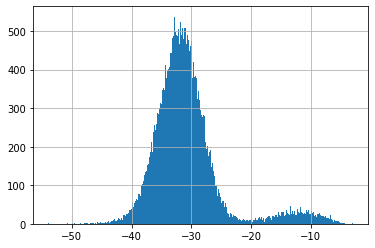

In [40]:
frog_region["Africa log"].hist(bins=1000)

<AxesSubplot:>

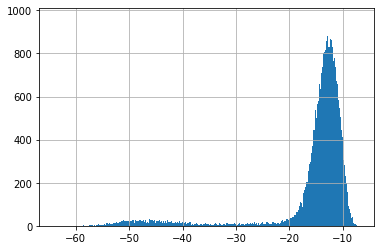

In [41]:
frog_region["Europe log"].hist(bins=1000)

## Merge with PCA values

In [42]:
frog_region=frog_region.reset_index().rename(columns={"Individual":"IID"})

In [43]:
pca=pd.read_csv("/cellar/users/mpagadal/ancestry-analysis/oncoarray/data/oncoarray_kidd_pca",delimiter="\t")

In [44]:
pca_frog=pd.merge(frog_region,pca,on=["IID"],how="left")

## Plot PCA plots

In [17]:
cutoffs=[-20,-15,-10]

82841
67828
5567


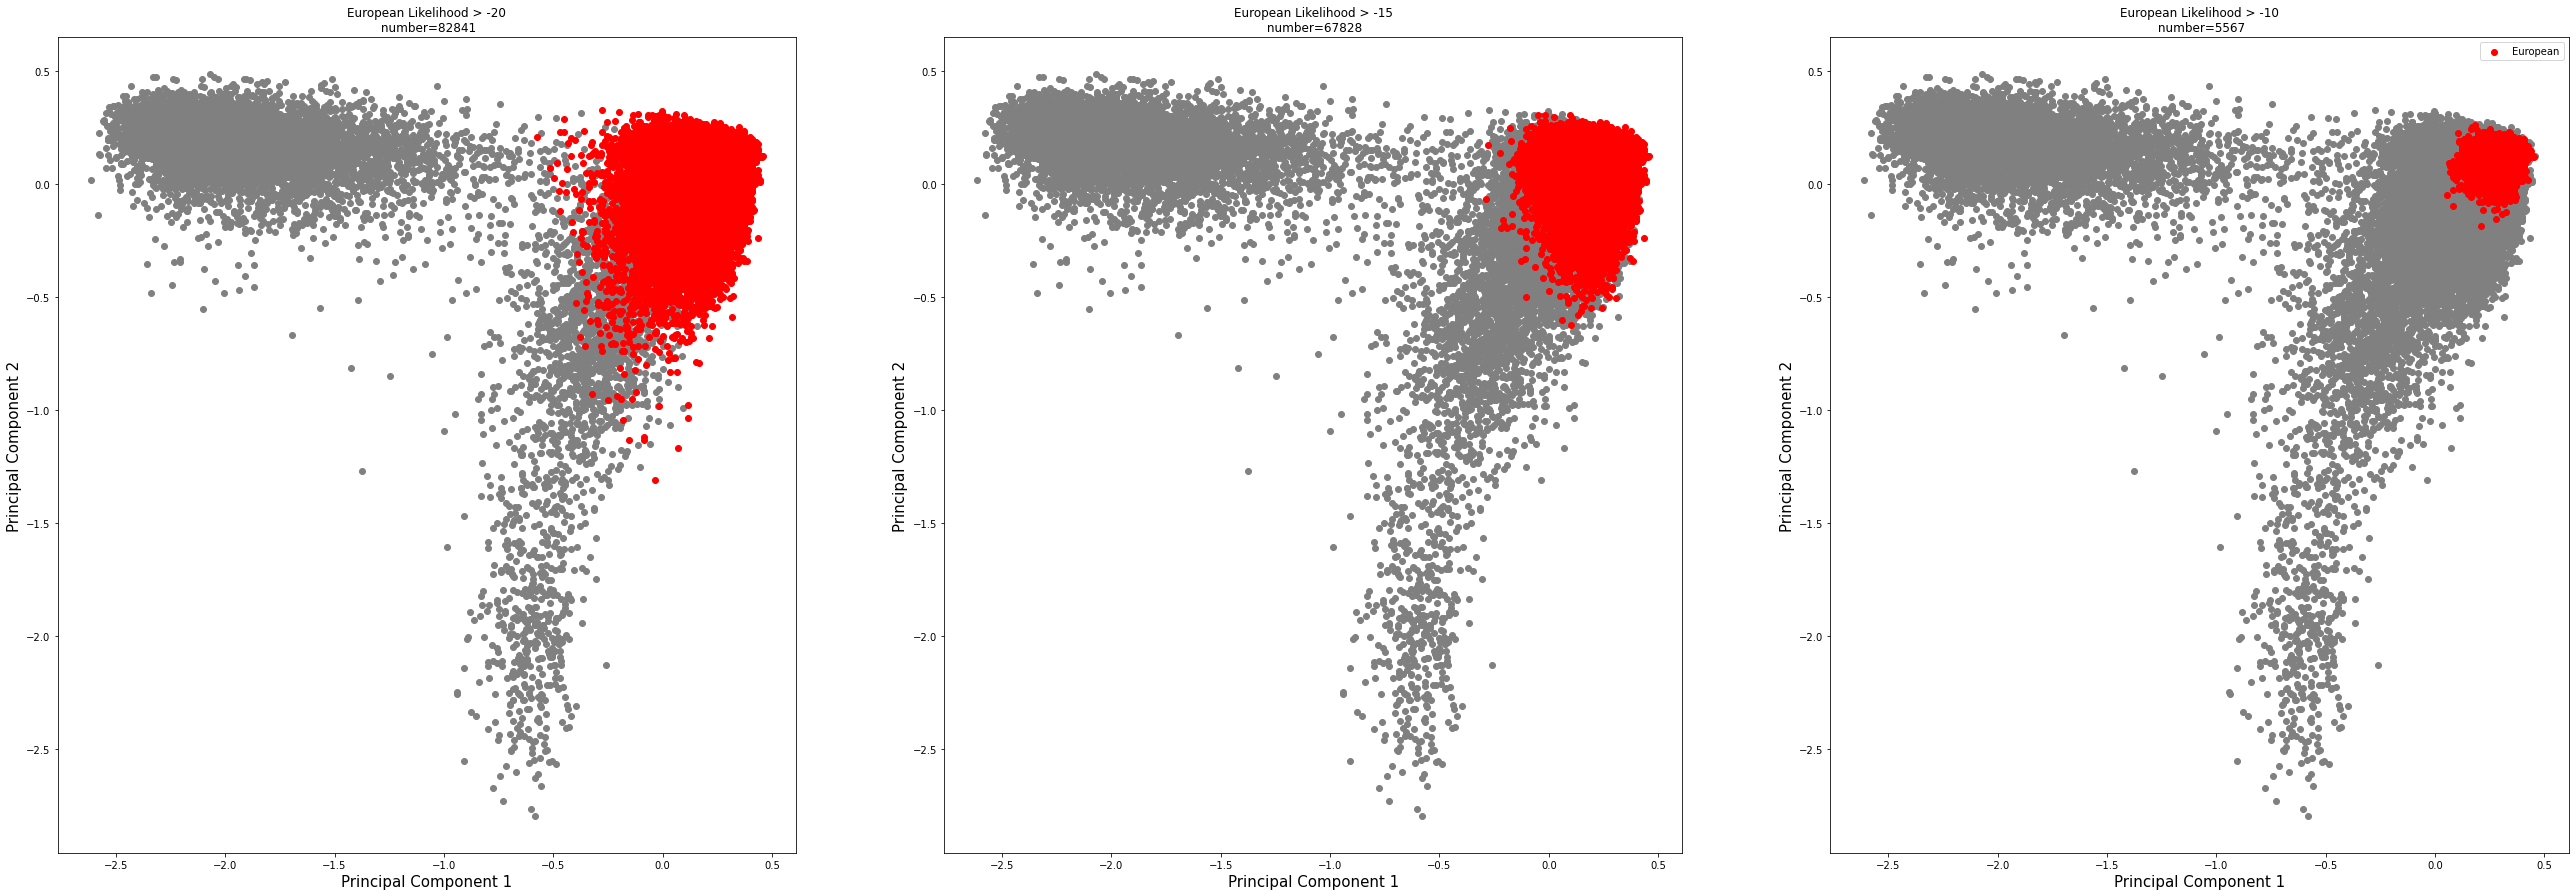

In [18]:
fig, axs = plt.subplots(1, 3,figsize=(45,15))

for i,x in enumerate(cutoffs):
    pca_frog["label"]=np.where((pca_frog["Europe log"]>x),"European","")
    print(len(pca_frog[pca_frog["label"]=="European"]))
    axs[i].scatter(pca_frog[pca_frog["label"]==""]["PC1"],pca_frog[pca_frog["label"]==""]["PC2"],
            color="gray",label="")
    axs[i].scatter(pca_frog[pca_frog["label"]=="European"]["PC1"],pca_frog[pca_frog["label"]=="European"]["PC2"],
            color="red",label="European")
    axs[i].set_ylabel("Principal Component 2",fontsize=15)
    axs[i].set_xlabel("Principal Component 1",fontsize=15)
    axs[i].set_title("European Likelihood > "+str(x)+"\n number="+str(len(pca_frog[pca_frog["label"]=="European"])))
plt.legend()   

6033
4533
1795


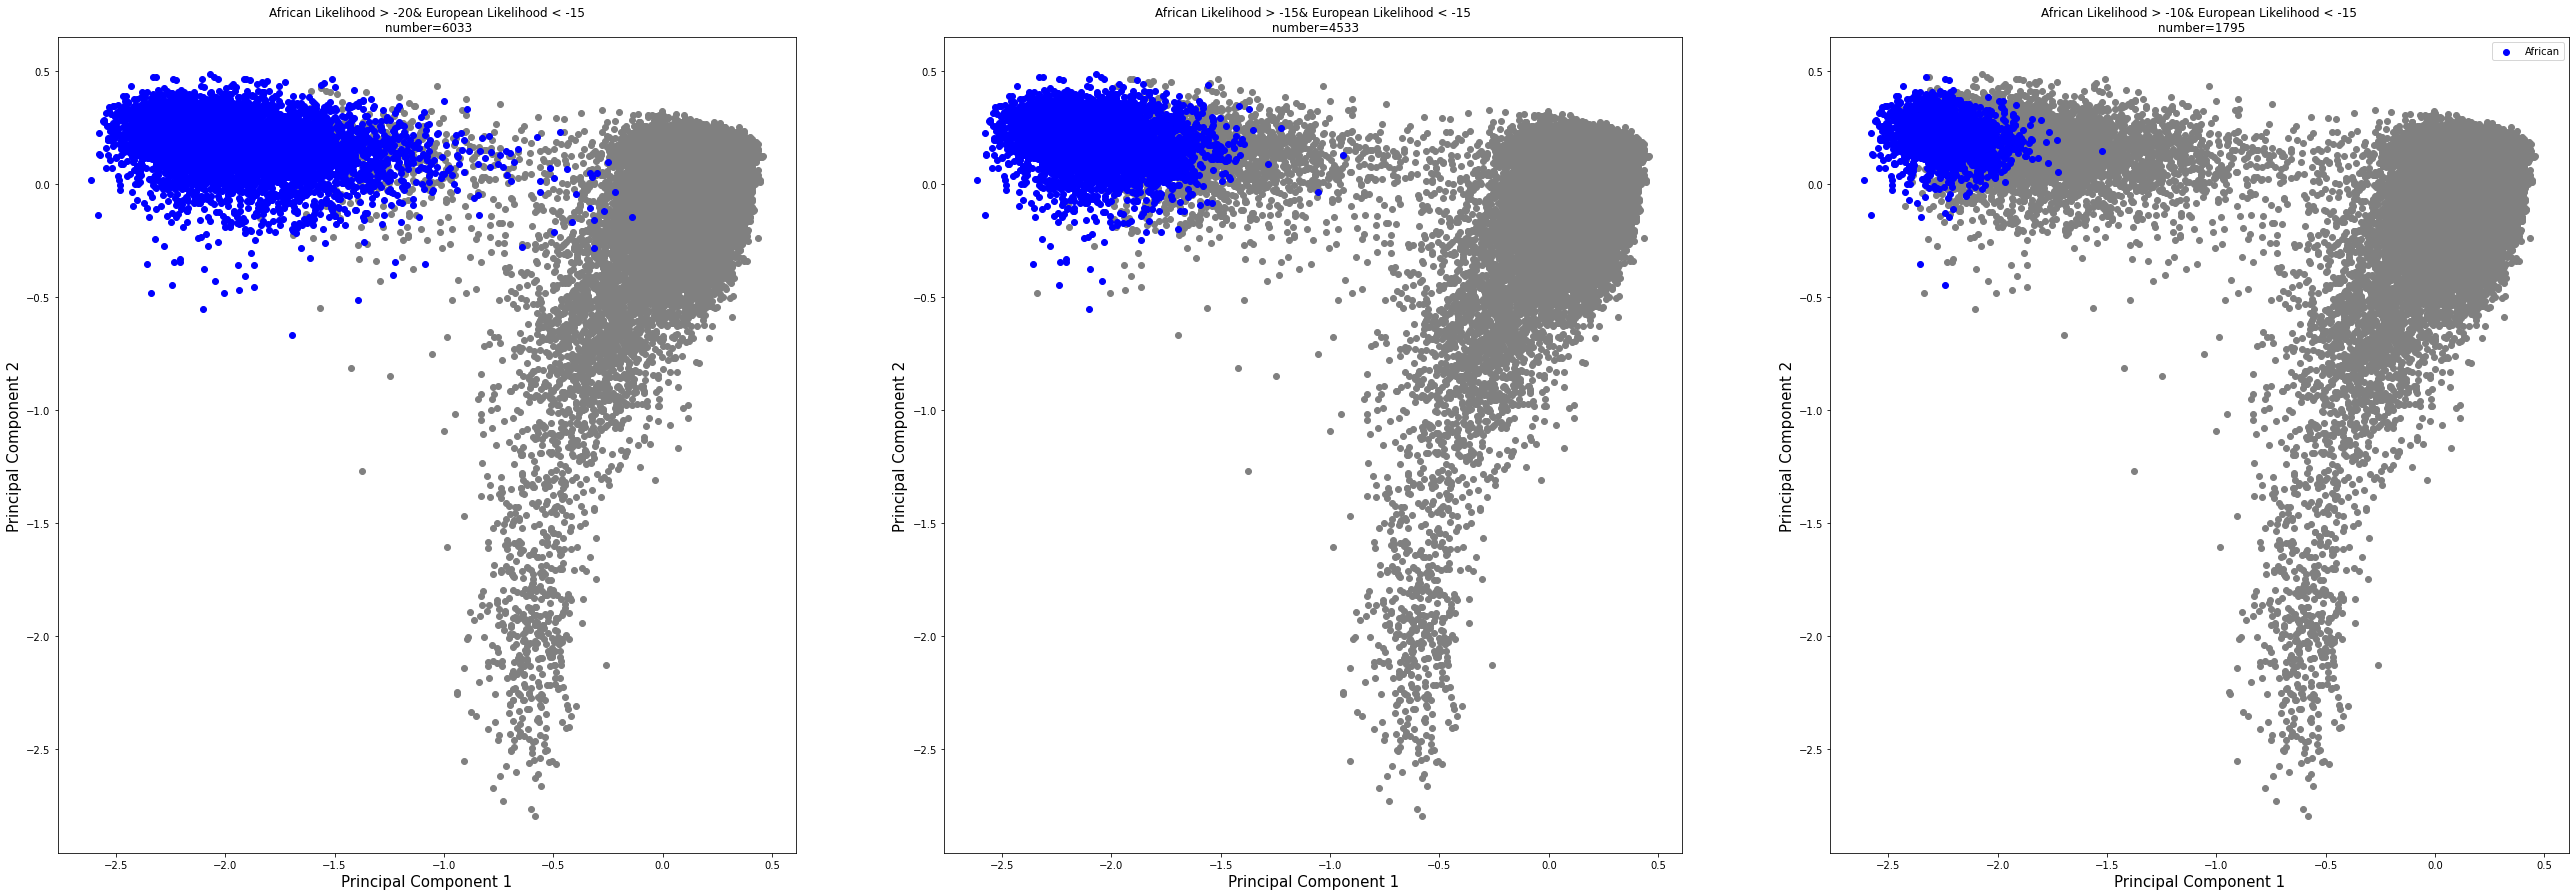

In [20]:
fig, axs = plt.subplots(1, 3,figsize=(45,15))

for i,x in enumerate(cutoffs):
    pca_frog["label"]=np.where((pca_frog["Africa log"]>x)&(pca_frog["Europe log"]< -15),"African","")
    print(len(pca_frog[pca_frog["label"]=="African"]))
    axs[i].scatter(pca_frog[pca_frog["label"]==""]["PC1"],pca_frog[pca_frog["label"]==""]["PC2"],
            color="gray",label="")
    axs[i].scatter(pca_frog[pca_frog["label"]=="African"]["PC1"],pca_frog[pca_frog["label"]=="African"]["PC2"],
            color="blue",label="African")
    axs[i].set_ylabel("Principal Component 2",fontsize=15)
    axs[i].set_xlabel("Principal Component 1",fontsize=15)
    axs[i].set_title("African Likelihood > "+str(x)+"& European Likelihood < -15\n number="+str(len(pca_frog[pca_frog["label"]=="African"])))
plt.legend()   

## Get finalized cohorts

In [21]:
pca_frog["label"]=np.where((pca_frog["Europe log"]>-10),"European","")
df_eur=pd.DataFrame({"FID":0,"IID":pca_frog[pca_frog["label"]=="European"]["IID"].tolist()})
df_eur.to_csv("../patients/all/european.cohort.txt",header=None,index=None,sep="\t")

In [22]:
pca_frog["label"]=np.where((pca_frog["Europe log"]<-15)&(pca_frog["Africa log"]>-15),"African","")
df_afr=pd.DataFrame({"FID":0,"IID":pca_frog[pca_frog["label"]=="African"]["IID"].tolist()})
df_afr.to_csv("../patients/all/african.cohort.txt",header=None,index=None,sep="\t")

## Get self-identified ancestry

In [25]:
self=pd.read_csv("/nrnb/users/mpagadal/oncoarray/patients/self-identified-ethnicity/compiled-self-identified-ancestry.txt",header=None,delimiter="\t")
mp_self=dict(zip(self[1],self[2]))

In [27]:
df_eur["self-identified"]=df_eur["IID"].map(mp_self)
df_afr["self-identified"]=df_afr["IID"].map(mp_self)

In [28]:
df_eur["self-identified"].value_counts()

european    5564
latino         3
Name: self-identified, dtype: int64

In [29]:
df_afr["self-identified"].value_counts()

african.ancestry    4532
latino                 1
Name: self-identified, dtype: int64